This is my first time using Jupyter Lab *and* Python 3, so we'll see how this goes.

In [1]:
from astropy.cosmology import FlatLambdaCDM
from astropy.io import fits
from astropy import units as u
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import patches
import matplotlib as mpl
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'stixgeneral'
%matplotlib inline
#matplotlib.matplotlib_fname()

### Read in the data

In [2]:
# This is the file that Song said to start with.
data_pth = '/Users/greg/Desktop/git_projects/catalog_plots/data/'
data_file_1 = data_pth + 's16a_massive_logmMax_11.45_z_0.25_0.47_mhalo_pdr_full.fits'
hdu1 = fits.open(data_file_1)

So here I'm going to list the useful bits of this data set:

`ra`: Right Ascension

`dec`: Declination
(*These will be useful when I make the galaxy map plot*)

`z_best`: Best redshift value

`logmh_host`: Virial mass


In [3]:
data_table = Table(hdu1[1].data) # For visualization, just in case.
# Make z cut 0.25<z<.45 , logm100 > 11.5

Now what I want to do is take the galaxy halo masses and assign them a radius. To do this, I will use  `Colossus` (Diemer 2017).

In [4]:
import colossus
from colossus.cosmology import cosmology
params = {'flat': True , 'H0': 70.0 , 'Om0': 0.3 , 'Ob0': 0.049, 'sigma8': 0.81, 'ns': 0.95}
h = .7
cosmology.addCosmology('huang18',params)
cosmology.setCosmology('huang18')
from colossus.halo import mass_so

In [5]:
data_table.colnames # find the useful columns

['object_id',
 'ra',
 'dec',
 'z_spec',
 'z_best',
 'z_phot',
 'z_type',
 'gcmodel_mag',
 'gcmodel_mag_err',
 'rcmodel_mag',
 'rcmodel_mag_err',
 'icmodel_mag',
 'icmodel_mag_err',
 'zcmodel_mag',
 'zcmodel_mag_err',
 'ycmodel_mag',
 'ycmodel_mag_err',
 'MSTAR',
 'logm_10',
 'logm_30',
 'logm_100',
 'logm_max',
 'vdisp_sdss',
 'vdisp_err_sdss',
 'logms_gama',
 'logms_err_gama',
 'id_cluster_redm',
 'p_mem_redm',
 'z_lambda_redm',
 'lambda_redm',
 'p_cen_1_redm',
 'id_camira',
 'z_camira',
 'n_cor_camira',
 'logms_camira',
 'r50_max',
 'r50_100',
 'logmh_peak',
 'logmh_vir',
 'logmh_host',
 'ra_pdr',
 'dec_pdr',
 'sep_arcsec_pdr']

In [6]:
# Put the (useful) data into nice arrays
logm100 = np.array(data_table['logm_100'])
z = np.array(data_table['z_best'])
z_best = []
logmh_host = []
ra = []
dec = []
logm_max = []
obj_id = []
for i in range(len(logm100)):
    if logm100[i] > 11.5 and z[i] > .25 and z[i] < .45:
        z_best.append(data_table['z_best'][i])
        logmh_host.append(data_table['logmh_host'][i])
        ra.append(data_table['ra'][i])
        dec.append(data_table['dec'][i])
        logm_max.append(data_table['logm_max'][i])
        obj_id.append(data_table['object_id'][i])
z_best = np.array(z_best)
logmh_host = np.array(logmh_host)
ra = np.array(ra)
dec = np.array(dec)
logm_max = np.array(logm_max)
obj_id = np.array(obj_id)
print(np.shape(logm_max))
print(np.shape(ra))

(2112,)
(2112,)


I want to split the data into four different fields. From Song:
* G09H  RA: 130-137 (133.5)  DEC: -0.25 - 2.30 (0.96)
* G12H  RA: 178-181 (179.5)  DEC: -1.38 - 1.21 (-0.09)
* G15H  RA: 214-219 (216.5)  DEC: -1.38-  1.21 (-0.09)
* HectoMap  RA: 244.0 - 247.0 (245.5)  DEC: 42.3 - 44.3 (42.8)

In [7]:
# G09H
g09h_ra = []
g09h_dec = []
g09h_logmh_host = []
g09h_z_best = []
g09h_logm_max = []
g09h_obj_id = []
for i in range(len(ra)):
    if ra[i] >= 130.0 and ra[i] <= 137.0 and dec[i] >= -0.25 and dec[i] <=2.30:
            g09h_ra.append(ra[i])
            g09h_dec.append(dec[i])
            g09h_logmh_host.append(logmh_host[i])
            g09h_z_best.append(z_best[i])
            g09h_logm_max.append(logm_max[i])
            g09h_obj_id.append(obj_id[i])

# Turn the lists into arrays
g09h_ra = np.array(g09h_ra)
g09h_dec = np.array(g09h_dec)
g09h_logmh_host = np.array(g09h_logmh_host)
g09h_z_best = np.array(g09h_z_best)
# Now to find r_halo
g09h_r_halo = mass_so.M_to_R((10**g09h_logmh_host)*h , g09h_z_best, 'vir')/h # kpc/h

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(g09h_z_best)
g09h_r_halo_deg = ((g09h_r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

# circles
g09h_halo_circle = []
for i in range(len(g09h_r_halo_deg)):
    g09h_halo_circle.append(Circle((g09h_ra[i],g09h_dec[i]),g09h_r_halo_deg[i],fill=False))

In [8]:
# G12H
g12h_ra = []
g12h_dec = []
g12h_logmh_host = []
g12h_z_best = []
g12h_logm_max = []
g12h_obj_id = []
for i in range(len(ra)):
    if ra[i] >= 178.0 and ra[i] <= 181.0 and dec[i] >= -1.38 and dec[i] <=1.21:
            g12h_ra.append(ra[i])
            g12h_dec.append(dec[i])
            g12h_logmh_host.append(logmh_host[i])
            g12h_z_best.append(z_best[i])
            g12h_logm_max.append(logm_max[i])
            g12h_obj_id.append(obj_id[i])

# Turn the lists into arrays
g12h_ra = np.array(g12h_ra)
g12h_dec = np.array(g12h_dec)
g12h_logmh_host = np.array(g12h_logmh_host)
g12h_z_best = np.array(g12h_z_best)
# Now to find r_halo
g12h_r_halo = mass_so.M_to_R((10**g12h_logmh_host)*h , g12h_z_best, 'vir')/h # kpc/h

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(g12h_z_best)
g12h_r_halo_deg = ((g12h_r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

# circles
g12h_halo_circle = []
for i in range(len(g12h_r_halo_deg)):
    g12h_halo_circle.append(Circle((g12h_ra,g12h_dec),g12h_r_halo_deg,fill=False))
g12h_circles = plt.Circle(g12h_halo_circle)

In [9]:
# G15H
g15h_ra = []
g15h_dec = []
g15h_logmh_host = []
g15h_z_best = []
g15h_logm_max = []
g15h_obj_id = []
for i in range(len(ra)):
    if ra[i] >= 214.0 and ra[i] <= 219.0 and dec[i] >= -1.38 and dec[i] <= 1.21:
            g15h_ra.append(ra[i])
            g15h_dec.append(dec[i])
            g15h_logmh_host.append(logmh_host[i])
            g15h_z_best.append(z_best[i])
            g15h_logm_max.append(logm_max[i])
            g15h_obj_id.append(obj_id[i])

# Turn the lists into arrays
g15h_ra = np.array(g15h_ra)
g15h_dec = np.array(g15h_dec)
g15h_logmh_host = np.array(g15h_logmh_host)
g15h_z_best = np.array(g15h_z_best)
# Now to find r_halo
g15h_r_halo = mass_so.M_to_R((10**g15h_logmh_host)*h , g15h_z_best, 'vir')/h # kpc/h

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(g15h_z_best)
g15h_r_halo_deg = ((g15h_r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

# circles
g15h_halo_circle = []
for i in range(len(g15h_r_halo_deg)):
    g15h_halo_circle.append(Circle((g15h_ra,g15h_dec),g15h_r_halo_deg,fill=False))
g15h_circles = plt.Circle(g15h_halo_circle)

In [10]:
# HectoMap
hm_ra = []
hm_dec = []
hm_logmh_host = []
hm_z_best = []
hm_logm_max = []
hm_obj_id = []
for i in range(len(ra)):
    if ra[i] >= 130.0 and ra[i] <= 137.0 and dec[i] >= -0.25 and dec[i] <=2.30:
            hm_ra.append(ra[i])
            hm_dec.append(dec[i])
            hm_logmh_host.append(logmh_host[i])
            hm_z_best.append(z_best[i])
            hm_logm_max.append(logm_max[i])
            hm_obj_id.append(obj_id[i])

# Turn the lists into arrays
hm_ra = np.array(hm_ra)
hm_dec = np.array(hm_dec)
hm_logmh_host = np.array(hm_logmh_host)
hm_z_best = np.array(hm_z_best)
# Now to find r_halo
hm_r_halo = mass_so.M_to_R((10**hm_logmh_host)*h , hm_z_best, 'vir')/h # kpc/h

# Turn the physical radius into an angular size in degrees
theta_per_kpc = FlatLambdaCDM(H0=70 , Om0= 0.3).arcsec_per_kpc_proper(hm_z_best)
hm_r_halo_deg = ((hm_r_halo*u.kpc * theta_per_kpc).to(u.deg))/u.deg

# circles
hm_halo_circle = []
for i in range(len(hm_r_halo_deg)):
    hm_halo_circle.append(Circle((hm_ra,g09h_dec),hm_r_halo_deg,fill=False))
hm_circles = plt.Circle(hm_halo_circle)

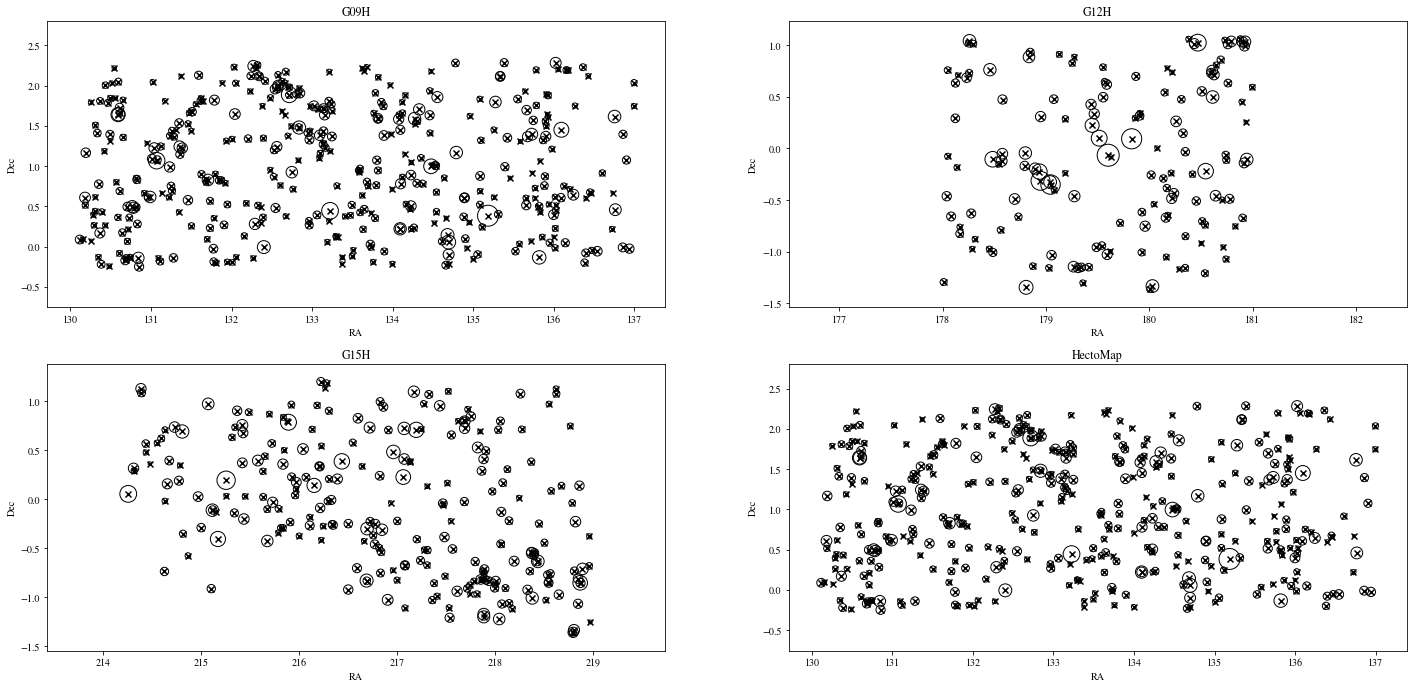

In [11]:
fig = plt.figure(figsize = (20, 10))
fig.subplots_adjust(left=0.05, right=0.994, 
                    bottom=0.12, top=0.994,
                    wspace=0.20, hspace=0.20)
#z_color = matplotlib.colors.Colormap('spectral',N=10000)

ax1 = fig.add_subplot(221)
ax1.scatter(g09h_ra , g09h_dec, marker = 'x' , color = 'k')
for i in range(len(g09h_r_halo_deg)):
    ax1.add_patch(patches.Circle((g09h_ra[i],g09h_dec[i]),g09h_r_halo_deg[i],fill=False))
ax1.title.set_text('G09H')
ax1.set_xlabel('RA')
ax1.set_ylabel('Dec')
ax1.axis('equal')

ax2 = fig.add_subplot(222)
ax2.scatter(g12h_ra , g12h_dec, marker = 'x' , color = 'k')
for i in range(len(g12h_r_halo_deg)):
    ax2.add_patch(patches.Circle((g12h_ra[i],g12h_dec[i]),g12h_r_halo_deg[i],fill=False))
ax2.title.set_text('G12H')
ax2.set_xlabel('RA')
ax2.set_ylabel('Dec')
ax2.axis('equal')

ax3 = fig.add_subplot(223)
ax3.scatter(g15h_ra , g15h_dec, marker = 'x' , color = 'k')
for i in range(len(g15h_r_halo_deg)):
    ax3.add_patch(patches.Circle((g15h_ra[i],g15h_dec[i]),g15h_r_halo_deg[i],fill=False))
ax3.title.set_text('G15H')
ax3.set_xlabel('RA')
ax3.set_ylabel('Dec')
ax3.axis('equal')

ax4 = fig.add_subplot(224)
ax4.scatter(hm_ra , hm_dec , marker = 'x' , color = 'k')
for i in range(len(hm_r_halo_deg)):
    ax4.add_patch(patches.Circle((hm_ra[i],hm_dec[i]),hm_r_halo_deg[i],fill=False))
ax4.title.set_text('HectoMap')
ax4.set_xlabel('RA')
ax4.set_ylabel('Dec')
ax4.axis('equal')

plt.savefig('field.eps',dpi=1000)

Now the goal is to rank order the galaxies by mass and determine how many satellites they have. To do that, I will order galaxies by mass, figure out how many galaxies are within r_halo and delta_z. Then I label them satellite or central.

In [12]:
from astropy.table import vstack, Column, unique
z_lim = 0.005

g09h_table = Table()
g09h_table['logm_max'] = g09h_logm_max
g09h_table['ra'] = g09h_ra
g09h_table['dec'] = g09h_dec
g09h_table['z_best'] = g09h_z_best
g09h_table['logmh_host'] = g09h_logmh_host
g09h_table['r_halo_deg'] = g09h_r_halo_deg
g09h_table['obj_id'] = g09h_obj_id

g12h_table = Table()
g12h_table['logm_max'] = g12h_logm_max
g12h_table['ra'] = g12h_ra
g12h_table['dec'] = g12h_dec
g12h_table['z_best'] = g12h_z_best
g12h_table['logmh_host'] = g12h_logmh_host
g12h_table['r_halo_deg'] = g12h_r_halo_deg
g12h_table['obj_id'] = g12h_obj_id

g15h_table = Table()
g15h_table['logm_max'] = g15h_logm_max
g15h_table['ra'] = g15h_ra
g15h_table['dec'] = g15h_dec
g15h_table['z_best'] = g15h_z_best
g15h_table['logmh_host'] = g15h_logmh_host
g15h_table['r_halo_deg'] = g15h_r_halo_deg
g15h_table['obj_id'] = g15h_obj_id

hm_table = Table()
hm_table['logm_max'] = hm_logm_max
hm_table['ra'] = hm_ra
hm_table['dec'] = hm_dec
hm_table['z_best'] = hm_z_best
hm_table['logmh_host'] = hm_logmh_host
hm_table['r_halo_deg'] = hm_r_halo_deg
hm_table['obj_id'] = hm_obj_id

cat_table = vstack([g09h_table,g12h_table,g15h_table,hm_table])
cat_table.sort('logm_max')

#### Song's code for satellite finding (to find the shape of PDR regoin). I am still trying to make a "Greg version" of this.

In [13]:
import copy
import math
def angular_distance(ra_1, dec_1, ra_arr_2, dec_arr_2):
    """Pure python code to computer angular distances between coordinates. 
    
    This is just the most straightforward Python code.
    Based on: https://github.com/phn/angles/blob/master/angles.py
    
    Return: 
        Angular distance in unit of deg
    """
    deg2rad = (math.pi / 180.0)
    
    xyz_1 = np.asarray([np.cos(dec_1 * deg2rad) * np.cos(ra_1 * deg2rad), 
                        np.cos(dec_1 * deg2rad) * np.sin(ra_1 * deg2rad),
                        np.sin(dec_1 * deg2rad)]).transpose()
    
    xyz_2 = np.asarray([np.cos(dec_arr_2 * deg2rad) * np.cos(ra_arr_2 * deg2rad), 
                        np.cos(dec_arr_2 * deg2rad) * np.sin(ra_arr_2 * deg2rad),
                        np.sin(dec_arr_2 * deg2rad)]).transpose()
    
    return np.arctan2(np.sqrt(np.sum(np.cross(xyz_1, xyz_2) ** 2.0, axis=1)),
                      np.sum(xyz_1 * xyz_2, axis=1)) / deg2rad
def find_satellite_single(idx, catalog, mass_col='logm_max', idx_col='idx_col',
                          ra_col='ra', dec_col='dec', flag_col='flag_satellite',
                          z_col='z_best', r_col='r_halo_deg'):
    """Find the satellite of a single object in a catalog."""
    # Isolate the target galaxy
    obj = catalog[idx]

    # Only use the ones that are less massive, and are not already identified 
    # as satellite 
    
    # Make a deepcopy, so won't affect the original catalog
    cat_use = copy.deepcopy(catalog[(catalog[mass_col] < obj[mass_col]) & 
                                    (~catalog[flag_col])])

    # First select the ones within the redshift boundary 
    # This will reduce the number of galaxies we need to calculate angular distance for
    cat_zlim = cat_use[np.abs(cat_use[z_col] - obj[z_col]) <= z_lim]

    if len(cat_zlim) > 0:
        # Make the angular distance cut
        cat_sat = cat_zlim[angular_distance(obj[ra_col], obj[dec_col], 
                                            cat_zlim[ra_col], cat_zlim[dec_col]) <= obj[r_col]]
        catalog[flag_col][cat_sat[idx_col]] = True
        return cat_sat
    
    # Just a trick to return an empty table 
    return cat_use[cat_use[z_col] < 0]


def find_satellite_catalog(input_table, sort_col='logm_max', idx_col='idx_col',
                           ra_col='ra', dec_col='dec', flag_col='flag_satellite',
                           z_col='z_best', r_col='r_halo_deg', z_lim=0.005):
    """Identify the satellite galaxies in the catalog."""
    # Sort catalog based on stellar mass 
    catalog = copy.deepcopy(input_table)
    catalog.sort(sort_col)

    # Reverse the order, so the most massive one is at the top
    catalog.reverse()

    # Add an original index array 
    catalog.add_column(Column(data=np.arange(len(catalog)), 
                              name=idx_col))

    # Add a flag array 
    catalog.add_column(Column(data=np.full(len(catalog), 0).astype(bool), 
                              name=flag_col))
    
    # Find the satellite galaxy for each object
    cat_sat = [find_satellite_single(idx, catalog, mass_col=sort_col,
                                     ra_col=ra_col, dec_col=dec_col,
                                     flag_col=flag_col, z_col=z_col,
                                     idx_col=idx_col,
                                     r_col=r_col) for idx in np.arange(len(catalog))]
    
    # Merge the catalogs for satellites
    cat_sat = vstack(cat_sat)
    cat_sat = unique(cat_sat)
    
    return catalog, cat_sat

In [14]:
pdr_new, pdr_sat = find_satellite_catalog(cat_table)

In [15]:
pdr_cen = pdr_new[~pdr_new['flag_satellite']]

hist_cen, edges_cen = np.histogram(pdr_cen['logm_max'], range=(11.5, 12.10),
                                   bins=8)

hist_sat, edges_sat = np.histogram(pdr_sat['logm_max'], range=(11.5, 12.10),
                                   bins=8)

mass_center = (edges_cen[1:] + edges_cen[:-1]) / 2

frac_sat = (hist_sat / hist_cen) * 100.0

frac_sat_err = (np.sqrt(hist_sat) / hist_cen) * 100.0

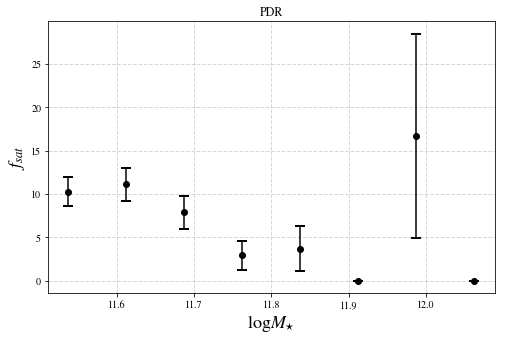

In [16]:
fig = plt.figure(figsize=(8,5))


ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.errorbar(mass_center, frac_sat, yerr=frac_sat_err, fmt='o',
             capthick=2, capsize=5, color = 'k')


ax1.set_xlabel(r'$ \log M_{\star}$', fontsize=18)
ax1.set_ylabel(r'$ f_{sat}$', fontsize=18)
ax1.set_title('PDR')
plt.savefig('pdr_satellite_fraction.png', dpi = 1000)

In [17]:
model = data_pth + 'um_smdpl_model_logms_tot_11.4.fits'
hdu1 = fits.open(model)

# create astropy table of useful data
model_table = Table()
model_table['logms_tot_mod'] = hdu1[1].data['logms_tot_mod']
model_table['upid'] = hdu1[1].data['upid']
model_table.sort('logms_tot_mod')

centrals_mod = []
sats_mod = []

for i in range(27241):
    if model_table['upid'][i] == -1:
        centrals_mod.append(model_table['logms_tot_mod'][i])
    else:
        sats_mod.append(model_table['logms_tot_mod'][i])    
# range of masses
mmin = np.min(model_table['logms_tot_mod'])
mmax = np.max(model_table['logms_tot_mod'])


# from Song's satellite finding code

hist_cen_mod, edges_cen_mod = np.histogram(centrals_mod, range = [11.5,mmax], bins=8)
hist_sat_mod, edges_sat_mod = np.histogram(sats_mod, range = [11.5,mmax], bins=8)

mass_center_mod = (edges_cen_mod[1:] + edges_cen_mod[:-1]) / 2

frac_sat_mod = (hist_sat_mod / hist_cen_mod) * 100

# fit line
fit = np.polyfit(mass_center_mod , frac_sat_mod , 5)
fit_fn = np.poly1d(fit)
x = np.arange(np.min(mass_center_mod) , np.max(mass_center_mod) , 0.01)

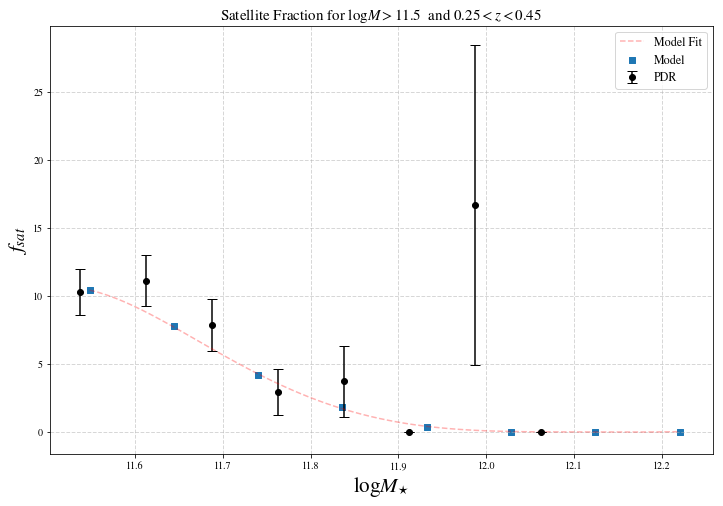

In [18]:
fig = plt.figure(figsize=(10,7))
fig.subplots_adjust(left=0.07, right=0.990, 
                    bottom=0.10, top=0.95,
                    wspace=0.20, hspace=0.20)

ax1 = fig.add_subplot(111)
ax1.grid(linewidth=1, linestyle='--', alpha=0.5)

ax1.plot(x, fit_fn(x), linestyle = '--', color = 'r', alpha = 0.3, label = 'Model Fit')
ax1.errorbar(mass_center, frac_sat, yerr=frac_sat_err, fmt='o',
             capthick=1, capsize=5, color = 'k', label = 'PDR')
ax1.scatter(mass_center_mod , frac_sat_mod, marker = 's', label = 'Model')


ax1.set_xlabel(r'$ \log M_{\star}$', fontsize=21)
ax1.set_ylabel(r'$ f_{sat}$', fontsize=21)
ax1.set_title('Satellite Fraction for $\log M > 11.5$  and $0.25 < z < 0.45$',fontsize=15)
ax1.legend(fontsize = 'large')

#ax2 = fig.add_subplot(122,sharey=ax1)
#ax2.grid(linewidth=1, linestyle='--', alpha=0.5)




#ax2.set_xlabel(r'$\log M_{\star max}$', fontsize = 21)
#ax2.set_ylabel(r'$f_{sat}$', fontsize = 21)
#ax2.set_title('Model',fontsize = 15)


plt.savefig('satellite_fraction_compare.png', dpi = 1000)